## Gait Video Study 
### Traditional ML algorithms on 2 task generalization frameworks, namely a) W-> WT b) VBW-> VBWT, to classify HOA/MS/PD strides and subjects 
#### Remember to add the original count of frames in a single stride (before down sampling via smoothing) for each stride as an additional artificial feature to add information about speed of the subject to the model

1. Save the optimal hyperparameters, confusion matrices and ROC curves for each algorithm.
2. Make sure to not use x, y, z, confidence = 0, 0, 0, 0 as points for the model since they are simply missing values and not data points, so make sure to treat them before inputting to model 
3. Make sure to normalize (z-score normalization) the features before we feed them to the model.
4. We use the summary statistics as range, CoV and asymmetry between the right and left limbs as the features to input to the traditional models requiring fixed size 1D input for each training/testing set sample.
5. Since we are implementating "pure" task generalization, we train and test on exactly same subjects i.e. we only retain common subjects across W and WT for a) and only retain common subjects across VBW and VBWT for b).


In [30]:
# 33 subject in total (~10 per group) 
# 4500 strides - 2000 strides - 200 groups for 10 strides per group
# STRIDE - 20*36 - MEAN SUBSTRACTION --- BATCH NORM. 
# 90 features - 36 Cov, 36 Range, 18 assymetry, 18 DEN
# Z-SCORE 
# Default + Dimensionality reduction - 3D space
# Try top 10 features 
# Subject generalization is where the overfitting issue is tested - If we get good results, that means we are not 
# overfitting 

#Check how is AUC 1 even when accurcay is low?

In [1]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import task_gen_traditionalML
reload(task_gen_traditionalML)
from ml_utils.task_gen_traditionalML import keep_subjects_common_across_train_test, normalize, models, evaluate
from ml_utils.task_gen_traditionalML import plot_ROC

In [2]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\MLresults\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,...,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,...,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,...,1.341021,8.625363,7.159495,3.366152,1.759968,17.545787,5.921325,8.243491,9.578638,3.008162
3,GVS_212_T_T1_4,HOA,BW,SLWT,GVS_212_T_T1,212,4,53,0,0.028511,...,2.375934,6.728268,0.098235,0.999027,0.541911,7.843339,4.279617,0.748023,19.471731,5.086056
4,GVS_212_T_T1_5,HOA,BW,SLWT,GVS_212_T_T1,212,5,44,0,0.025213,...,8.525816,1.775282,0.033210,9.166863,1.354601,6.674183,8.479480,4.373622,0.315168,11.795593


### main() 

### Task generalization framework 1: train on walking (W) and test on walking while talking (WT) to classify HOA/MS/PD strides and subjects 

In [3]:
#Trial W for training 
trialW = data[data['scenario']=='W']
#Trial WT for testing 
trialWT = data[data['scenario']=='WT']

#Trial W and WT after making sure both training and testing sets have common subjects 
trialW_reduced, trialWT_reduced = keep_subjects_common_across_train_test(trialW, trialWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))
print ('Training set (trial W):', trialW_reduced.groupby(['cohort'])['PID'].value_counts())
print ('Testing set (trial WT):', trialWT_reduced.groupby(['cohort'])['PID'].value_counts())
cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialW_reduced = shuffle(trialW_reduced, random_state = 0)
trainX = trialW_reduced.drop(cols_to_drop, axis = 1)
trainY = trialW_reduced[['PID', 'label']]
print ('Training shape', trainX.shape, trainY.shape)

#Shuffling the testing stride data 
trialWT_reduced = shuffle(trialWT_reduced, random_state = 0)
testX = trialWT_reduced.drop(cols_to_drop, axis = 1)
testY = trialWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX.shape, testY.shape)

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(trainX, 'z')
trainX_norm = (trainX-norm_mean)/norm_sd
testX_norm = (testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialWT_reduced['cohort'].value_counts()/trialWT_reduced['cohort'].value_counts()['HOA'])

framework = 'WtoWT' #Defining the task generalization framework of interest

Original number of subjects in training and test sets: 32 26
Subjects in test set, which are not in training set
[403]
Subjects in training set, which are not in test set
[312, 102, 112, 113, 115, 123, 124]
Number of subjects in training and test sets after reduction: 25 25
Training set (trial W): cohort  PID
HOA     215    45
        218    45
        212    44
        213    43
        216    40
        219    40
        217    39
        214    38
MS      320    45
        311    43
        310    41
        322    40
        323    40
        321    39
        313    38
        314    38
        318    17
PD      406    44
        408    44
        409    44
        404    41
        405    41
        410    41
        407    39
        411    39
Name: PID, dtype: int64
Testing set (trial WT): cohort  PID
HOA     217    47
        212    46
        213    45
        218    45
        215    44
        219    44
        216    42
        214    38
MS      320    47
        323    47

In [4]:
trialW['PID'].unique()

array([212, 213, 214, 215, 216, 217, 218, 219, 310, 311, 312, 313, 314,
       318, 320, 321, 322, 323, 404, 405, 406, 407, 408, 409, 410, 411,
       102, 112, 113, 115, 123, 124], dtype=int64)

In [5]:
save_results = False
# ml_models = ['logistic_regression']
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  \
             'linear_svm', 'mlp']
metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 

#For storing predicted probabilities for person (for all classes HOA/MS/PD) to show ROC curves 
predicted_probs_person = pd.DataFrame(columns = [ml_model + cohort for ml_model in ml_models for cohort in ['_HOA', '_MS', '_PD'] ]) 

logistic_regression
Stride-based model performance (Macro):  0.7795275590551181 0.783083460435621 0.7781255150733063 0.7781961603260857 0.911542459289001
Stride-based model performance (Micro):  0.7795275590551181 0.7795275590551181 0.7795275590551181 0.7795275590551181 None
Stride-based model performance (Weighted):  0.7795275590551181 0.7823036991939775 0.7795275590551181 0.7784783609010044 0.9116939490673601
Stride-based model performance (Class-wise):  0.7795275590551181 [0.7382716  0.76870748 0.84227129] [0.85185185 0.68072289 0.8018018 ] [0.79100529 0.72204473 0.82153846] None
LogisticRegression(random_state=0)
Person-based model performance (Macro):  0.92 0.9333333333333332 0.9259259259259259 0.9212962962962964 1.0
Person-based model performance (Micro):  0.92 0.92 0.92 0.92 None
Person-based model performance (Weighted):  0.92 0.9359999999999999 0.92 0.9194444444444446 1.0
Person-based model performance (Class-wise):  0.92 [0.8 1.  1. ] [1.         0.77777778 1.        ] [0.888

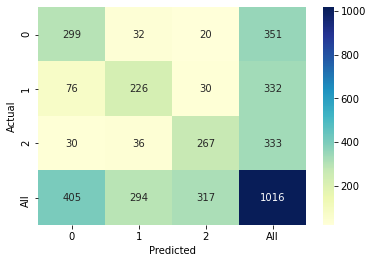

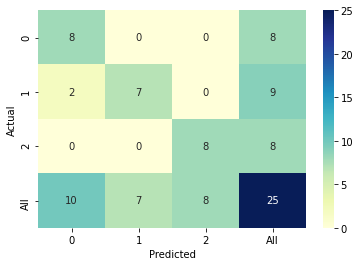

********************************
random_forest


In [ ]:
for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(trainX_norm, trainY, testX_norm, testY, ml_model, framework, results_path, save_results)  
    metrics[ml_model] = stride_person_metrics
    predicted_probs_person[ml_model+'_HOA'] = predict_probs_person[0]
    predicted_probs_person[ml_model+'_MS'] = predict_probs_person[1]
    predicted_probs_person[ml_model+'_PD'] = predict_probs_person[2]
    print ('********************************')

metrics.index = ['stride_accuracy', 'stride_precision_macro', 'stride_precision_micro', 'stride_precision_weighted', \
                 'stride_precision_class_wise', 'stride_recall_macro', 'stride_recall_micro', \
                 'stride_recall_weighted', 'stride_recall_class_wise', \
                 'stride_F1_macro', 'stride_F1_micro', 'stride_F1_weighted', 'stride_F1_class_wise', \
                 'stride_AUC_macro', 'stride_AUC_micro', 'stride_AUC_weighted',\
                 'stride_AUC_class_wise', 'person_accuracy', 'person_precision_macro', 'person_precision_micro', \
                 'person_precision_weighted', \
                 'person_precision_class_wise', 'person_recall_macro', 'person_recall_micro', \
                 'person_recall_weighted', 'person_recall_class_wise', \
                 'person_F1_macro', 'person_F1_micro', 'person_F1_weighted', 'person_F1_class_wise', \
                 'person_AUC_macro', 'person_AUC_micro', 'person_AUC_weighted', 'person_AUC_class_wise']  
if save_results:
    metrics.to_csv(results_path+ framework+ '\\task_generalize_'+framework+'_result_metrics.csv')
    predicted_probs_person.to_csv(results_path +framework+ '\\task_generalize_'+framework+'_prediction_probs.csv')

In [ ]:
metrics

In [ ]:
plot_ROC(ml_models, testY, predicted_probs_person, framework, results_path, save_results)

###  Task generalization framework 2: train on virtual beam walking (VBW) and test on virtual beam walking while talking (VBWT) with traditional ML algorithms to classify strides and subjects in HOA/MS/PD groups

In [ ]:
#Trial VBW for training 
trialVBW = data[data['scenario']=='SLW']
#Trial VBWT for testing 
trialVBWT = data[data['scenario']=='SLWT']

#Trial VBW and VBWT after making sure both training and testing sets have common subjects 
trialVBW_reduced, trialVBWT_reduced = keep_subjects_common_across_train_test(trialVBW, trialVBWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialVBW_reduced = shuffle(trialVBW_reduced, random_state = 0)
trainX_VBW = trialVBW_reduced.drop(cols_to_drop, axis = 1)
trainY_VBW = trialVBW_reduced[['PID', 'label']]
print ('Training shape', trainX_VBW.shape, trainY_VBW.shape)

#Shuffling the testing stride data 
trialVBWT_reduced = shuffle(trialVBWT_reduced, random_state = 0)
testX_VBWT = trialVBWT_reduced.drop(cols_to_drop, axis = 1)
testY_VBWT = trialVBWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX_VBWT.shape, testY_VBWT.shape)

#Normalize according to z-score standardization
norm_mean_VB, norm_sd_VB = normalize(trainX_VBW, 'z')
trainX_norm_VBW = (trainX_VBW-norm_mean_VB)/norm_sd_VB
testX_norm_VBWT = (testX_VBWT-norm_mean_VB)/norm_sd_VB

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialVBW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialVBW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialVBWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialVBWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialVBWT_reduced['cohort'].value_counts()/trialVBWT_reduced['cohort'].value_counts()['HOA'])

framework = 'VBWtoVBWT' #Defining the task generalization framework of interest

In [ ]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_VB = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for classes HOA/MS/PD) to show ROC curves 
predicted_probs_person_VB = pd.DataFrame(columns = [ml_model + cohort for ml_model in ml_models for cohort in ['_HOA', '_MS', '_PD'] ]) 

In [ ]:
for ml_model in ml_models:
    print (ml_model)
    predict_probs_person_VB, stride_person_metrics_VB = models(trainX_norm_VBW, trainY_VBW, testX_norm_VBWT, testY_VBWT, ml_model, \
                                                              framework, results_path, save_results)
    metrics_VB[ml_model] = stride_person_metrics_VB
    predicted_probs_person_VB[ml_model+'_HOA'] = predict_probs_person_VB[0]
    predicted_probs_person_VB[ml_model+'_MS'] = predict_probs_person_VB[1]
    predicted_probs_person_VB[ml_model+'_PD'] = predict_probs_person_VB[2]
    print ('********************************')

metrics_VB.index = ['stride_accuracy', 'stride_precision_macro', 'stride_precision_micro', 'stride_precision_weighted', \
                 'stride_precision_class_wise', 'stride_recall_macro', 'stride_recall_micro', \
                 'stride_recall_weighted', 'stride_recall_class_wise', \
                 'stride_F1_macro', 'stride_F1_micro', 'stride_F1_weighted', 'stride_F1_class_wise', \
                 'stride_AUC_macro', 'stride_AUC_micro', 'stride_AUC_weighted',\
                 'stride_AUC_class_wise', 'person_accuracy', 'person_precision_macro', 'person_precision_micro', \
                 'person_precision_weighted', \
                 'person_precision_class_wise', 'person_recall_macro', 'person_recall_micro', \
                 'person_recall_weighted', 'person_recall_class_wise', \
                 'person_F1_macro', 'person_F1_micro', 'person_F1_weighted', 'person_F1_class_wise', \
                 'person_AUC_macro', 'person_AUC_micro', 'person_AUC_weighted', 'person_AUC_class_wise']  
if save_results:
    metrics_VB.to_csv(results_path+ framework+ '\\task_generalize_'+framework+'_result_metrics.csv')
    predicted_probs_person_VB.to_csv(results_path+framework+'\\task_generalize_'+framework+'_prediction_probs.csv')

In [ ]:
metrics_VB

In [ ]:
#ROC 
plot_ROC(ml_models, testY_VBWT, predicted_probs_person_VB, framework, results_path, save_results)

In [ ]:
#Confusion matrices - Done
#micro/macro/weighted metric scores 
#Why is AUC 1 for low accuracy